##Classification of US quarters

In [1]:
# load data from google drive
!unzip /content/drive/MyDrive/data_quarters.zip

Archive:  /content/drive/MyDrive/data_quarters.zip
   creating: images_sorted/US.Quarter.2021.Alabama.Reverse/
replace images_sorted/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: images_sorted/.DS_Store  
  inflating: __MACOSX/images_sorted/._.DS_Store  
   creating: images_sorted/US.Quarter.2009.US Virgin Islands.Reverse/
  inflating: images_sorted/US.Quarter.2020.Vermont.Reverse/002.jpg  
  inflating: images_sorted/US.Quarter.2020.Vermont.Reverse/001.jpg  
  inflating: images_sorted/US.Quarter.2020.Vermont.Reverse/000.jpg  
  inflating: images_sorted/US.Quarter.2005.Oregon.Reverse/002.jpg  
  inflating: images_sorted/US.Quarter.2005.Oregon.Reverse/003.jpg  
  inflating: images_sorted/US.Quarter.2005.Oregon.Reverse/001.jpg  
  inflating: images_sorted/US.Quarter.2005.Oregon.Reverse/000.jpg  
  inflating: images_sorted/US.Quarter.2005.Oregon.Reverse/004.jpg  
  inflating: images_sorted/US.Quarter.2005.Oregon.Reverse/005.jpg  
  inflating: images_sorted/US.Quarter.2005

In [2]:
# find empty directories and delete them

!find images_sorted -type d -empty -exec rmdir {} \;


find: ‘images_sorted/US.Quarter.2021.Alabama.Reverse’: No such file or directory
find: ‘images_sorted/US.Quarter.2009.US Virgin Islands.Reverse’: No such file or directory


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

import keras
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt

from keras import backend as K




from keras.applications import resnet50


import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot



import time




In [4]:
batch_size = 32
img_height = 256
img_width =  256

In [5]:
# data generators

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2)

train_generator = datagen.flow_from_directory(
                    'images_sorted',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123,
                    subset='training')


valid_generator = datagen.flow_from_directory(
                    'images_sorted',
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    shuffle=True,
                    seed=123,
                    subset='validation')
        





Found 1043 images belonging to 111 classes.
Found 187 images belonging to 111 classes.


In [6]:
X_train=[]
y_train=[]

train_generator.reset()

for i in range(train_generator.__len__()):
   a,b=train_generator.next()
   X_train.extend(a)
   y_train.extend(b)


X_train=np.array(X_train)
y_train=np.array(y_train)

In [7]:
X_valid=[]
y_valid=[]

valid_generator.reset()

for i in range(valid_generator.__len__()):
   a,b=valid_generator.next()
   X_valid.extend(a)
   y_valid.extend(b)


X_valid=np.array(X_valid)
y_valid=np.array(y_valid)


In [8]:
n_classes=len(y_train[0])
n_classes

111

In [9]:
y_train = np.array([y_train[i].tolist().index(1) for i in range(len(y_train))])
y_valid = np.array([y_valid[i].tolist().index(1) for i in range(len(y_valid))])

In [10]:
# Data augmentation

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=90,
            zoom_range=0.5,
            height_shift_range=0.1,
            width_shift_range=0.1)

In [11]:
def get_pairs(batch_size,test=False):

  if test:

    X = X_valid
    y = y_valid
    
  else:

    X = X_train
    y = y_train


   

  n, img_height,img_width, c = X_train.shape

  pairs=[np.zeros((batch_size, img_height, img_width,c)) for i in range(2)]
  targets=np.zeros((batch_size))

  targets[batch_size//2:] = 1




  for i in range(batch_size):

    
    idx1 = np.random.randint(0,n)

    pairs[0][i,:,:,:] = data_augmentation.flow(X[idx1:idx1+1])[0][0] # apply data augmentation


    idx2 = np.random.randint(0,n)

    # first half of the set: images are from different classes
    if i < batch_size//2 :
      
      
      while y[idx1] == y[idx2]:  # if from same class

        idx2 = np.random.randint(0,n)  #try another random index
    
    # second half of the set: images are from the same class

    # this part was rewritten to optimize generation from large datasets

    if i >= batch_size//2 :
      
      
      y0 = y[idx1]

      # generate an array of indices of the elements from the same class as element idx1
      indices = [i for i, y in enumerate(y_train) if y == y0]
      
      # and get a random element from this array
      idx2 = indices[ np.random.randint(0,len(indices))]

     

    pairs[1][i,:,:,:] = data_augmentation.flow(X[idx2:idx2+1])[0][0]  # apply data augmentation



  return pairs, targets

In [12]:
def pairs_generator(batch_size, test = False):
    while True:
        pairs, targets = get_pairs(batch_size,test = test)
        yield (pairs, targets)

In [13]:
# Siamese network

input_left = Layers.Input((img_width,img_height,3))
input_right = Layers.Input((img_width,img_height,3))


resnet_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

base_model = tf.keras.Sequential()
base_model.add(resnet_model)
base_model.add(Layers.GlobalAveragePooling2D())

encoded_left = base_model(input_left)
encoded_right = base_model(input_right)



L1_layer = Layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_left, encoded_right])


prediction = Layers.Dense(1,activation='sigmoid')(L1_distance)

model = tf.keras.models.Model(inputs=[input_left,input_right],outputs=prediction)



model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         23587712    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2048)         0           sequential[0][0]             

In [17]:
model.compile(loss="binary_crossentropy",optimizer = keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])


In [18]:
batch_size = 32
steps_per_epoch = X_train.shape[0]//batch_size

In [19]:
tic = time.time()

trained = model.fit(
            pairs_generator(batch_size),
            steps_per_epoch=steps_per_epoch,
            epochs=30,
            )

toc=time.time()    
print(str(toc-tic)+ ' s')

Epoch 1/30
32/32 [==============================] - 44s 972ms/step - loss: 0.7214 - accuracy: 0.5690
Epoch 2/30
32/32 [==============================] - 31s 978ms/step - loss: 0.5139 - accuracy: 0.7207
Epoch 3/30
32/32 [==============================] - 31s 971ms/step - loss: 0.3686 - accuracy: 0.8359
Epoch 4/30
32/32 [==============================] - 30s 945ms/step - loss: 0.2576 - accuracy: 0.8829
Epoch 5/30
32/32 [==============================] - 30s 943ms/step - loss: 0.2350 - accuracy: 0.8970
Epoch 6/30
32/32 [==============================] - 30s 936ms/step - loss: 0.1867 - accuracy: 0.9282
Epoch 7/30
32/32 [==============================] - 31s 984ms/step - loss: 0.1741 - accuracy: 0.9361
Epoch 8/30
32/32 [==============================] - 32s 994ms/step - loss: 0.1614 - accuracy: 0.9504
Epoch 9/30
32/32 [==============================] - 31s 962ms/step - loss: 0.1603 - accuracy: 0.9465
Epoch 10/30
32/32 [==============================] - 31s 965ms/step - loss: 0.2114 - accura

In [20]:
# save model
t = time.time()

export_path_keras =  "/content/drive/MyDrive/models/siamese_quarters/{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/models/siamese_quarters/1608307102.h5


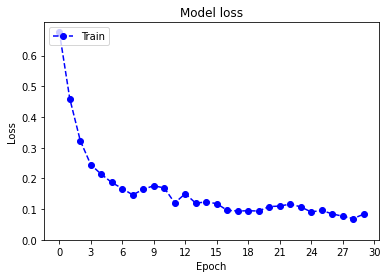

In [21]:
plt.plot(trained.history['loss'],'bo--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.xticks(np.arange(0,31,3))
plt.yticks(np.arange(0,0.7,0.1))
plt.show()

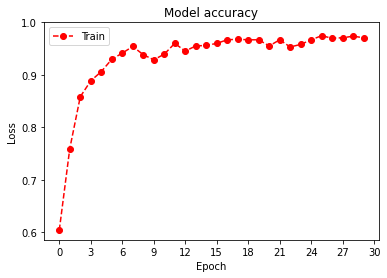

In [26]:
plt.plot(trained.history['accuracy'],'ro--')
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.xticks(np.arange(0,31,3))
plt.yticks(np.arange(0.6,1.01,0.1))
plt.show()

In [28]:
import pickle

f=open("/content/drive/MyDrive/models/siamese_quarters/trained_loss.obj",'wb')


pickle.dump(trained.history['loss'],f)


In [29]:
f=open("/content/drive/MyDrive/models/siamese_quarters/trained_accuracy.obj",'wb')


pickle.dump(trained.history['accuracy'],f)


In [11]:
# load model after session crashed

import_path_keras='/content/drive/MyDrive/models/siamese_quarters/1608303221.h5'

model = tf.keras.models.load_model(import_path_keras)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2048)         23587712    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2048)         0           sequential_1[0][0]         

In [30]:
def one_shot_task(X_valid1,X_train,y_train):

  pairs=[np.zeros((n_classes, img_height, img_width,3)) for i in range(2)]

  n_samples = len(y_train)

  for i in range(n_classes):

     pairs[0][i,:,:,:] = X_valid1





  for i in range(n_classes):

   
     # this part was rewritten to optimize speed:


     # generate an array of indices of the elements from the same class as element idx1
     indices = [j for j, y in enumerate(y_train) if y == i]
      
     # and get a random element from this array
     idx2 = indices[ np.random.randint(0,len(indices))]

     pairs[1][i,:,:,:] = X_train[idx2]

  return pairs

In [31]:
def test_accuracy(X_valid,y_valid,X_train,y_train):

  n_correct = 0
  n_all = len(X_valid)

  for i in range(n_all):

    pred = np.argmax( model.predict(one_shot_task(X_valid[i],X_train,y_train)) )

    if y_valid[i] == pred:

      n_correct+=1

      if i!=0 and i%10 == 0: print('step:', i, 'accuracy:', 100 * n_correct/(i+1))

  accuracy = 100.0 * n_correct / n_all
  print('step:', n_all, 'accuracy:',  accuracy)


  return accuracy



In [32]:
# enable garbage collector: RAM full, environment crashes when trying to run accuracy on test set

import gc
gc.enable()

In [33]:
# accuracy on validation data set

tic=time.time()

test_accuracy(X_valid,y_valid,X_train,y_train)

toc=time.time()   
print(str(toc-tic)+ ' s')

step: 10 accuracy: 90.9090909090909
step: 20 accuracy: 90.47619047619048
step: 30 accuracy: 87.09677419354838
step: 40 accuracy: 90.2439024390244
step: 50 accuracy: 90.19607843137256
step: 60 accuracy: 88.52459016393442
step: 70 accuracy: 87.32394366197182
step: 80 accuracy: 86.41975308641975
step: 90 accuracy: 84.61538461538461
step: 100 accuracy: 83.16831683168317
step: 130 accuracy: 81.6793893129771
step: 150 accuracy: 82.11920529801324
step: 170 accuracy: 83.04093567251462
step: 180 accuracy: 83.42541436464089
step: 187 accuracy: 83.9572192513369
100.9387903213501 s


In [34]:
def test_accuracy_augment(X_valid,y_valid,X_train,y_train):

  n_correct = 0
  n_all = len(X_valid)

  for i in range(n_all):

    pred = np.argmax( model.predict(one_shot_task(data_augmentation.flow(X_valid[i:i+1])[0][0],X_train,y_train)) )

    if y_valid[i] == pred:

      n_correct+=1

      if i!=0 and i%10 == 0: print('step:', i, 'accuracy:', 100 * n_correct/(i+1))

  accuracy = 100.0 * n_correct / n_all
  print('step:', n_all, 'accuracy:', accuracy)

  return accuracy

In [35]:
# test accuracy applying data augmentation on validation dataset
tic=time.time()

test_accuracy_augment(X_valid,y_valid,X_train,y_train)

toc=time.time()   
print(str(toc-tic)+ ' s')

step: 10 accuracy: 90.9090909090909
step: 20 accuracy: 85.71428571428571
step: 30 accuracy: 87.09677419354838
step: 40 accuracy: 90.2439024390244
step: 50 accuracy: 88.23529411764706
step: 60 accuracy: 86.88524590163935
step: 70 accuracy: 87.32394366197182
step: 80 accuracy: 87.65432098765432
step: 90 accuracy: 85.71428571428571
step: 100 accuracy: 85.14851485148515
step: 110 accuracy: 85.58558558558559
step: 140 accuracy: 80.85106382978724
step: 150 accuracy: 81.45695364238411
step: 160 accuracy: 81.98757763975155
step: 170 accuracy: 81.87134502923976
step: 180 accuracy: 81.76795580110497
step: 187 accuracy: 81.81818181818181
100.32203006744385 s
